In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2

%matplotlib inline

In [3]:
train_x = pd.read_csv('input/train_x.csv', index_col=0, header=None)
train_y = pd.read_csv('input/train_y.csv', index_col=0)
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)

In [4]:
test_x.shape

(4800, 3072)

In [7]:
import matplotlib
matplotlib.use("Agg")
 
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
# from keras.utils import np_utils
import gc 

import pandas as pd 
import matplotlib.pyplot as plt 
import os
from keras.utils import np_utils
import cv2

%matplotlib inline

Using TensorFlow backend.


In [8]:
EPOCHS = 100
INIT_LR = 1e-3
IMAGE_DIMS = (32 , 32 , 3)
BATCH_SIZE = 520

In [9]:
mappping_type = {'Bird': 0, 'Airplane': 1}
train_y_bin = train_y.replace({"target": mappping_type})

In [10]:
d1 = [[np.array(x)] for x in train_x.values]
d = {'map': d1, 'target': train_y_bin.target}

In [11]:
df = pd.DataFrame(data=d)

In [12]:
df.map.shape

(7200,)

In [13]:
df.head()

,map,target
0,"[[4, 20, 18, 4, 16, 15, 2, 11, 9, 2, 6, 5, 1, ...",0
1,"[[109, 155, 233, 109, 155, 231, 110, 156, 232,...",1
2,"[[156, 172, 195, 158, 174, 197, 158, 174, 197,...",1
3,"[[115, 108, 52, 97, 100, 79, 86, 107, 98, 79, ...",1
4,"[[167, 205, 221, 160, 198, 213, 161, 198, 214,...",1


In [21]:
def make_image_gen_cat(in_df, batch_size=BATCH_SIZE):
    all_batches = in_df.sample(frac=1)
    out_map = []
    out_class = []
    while True:
        for index, row in in_df.iterrows():
#             out_map += [np.expand_dims(row.waferMap, -1)]
#             out_map += [row.map]
            out_map += [pd.Series(row).values[0][0]]
#             print(pd.Series(row).values[0][0])
            out_class += [row.target]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
                yield np.stack(out_map, 0), np.array(np_utils.to_categorical(out_class, num_classes=2))
                out_map = []
                out_class = []

In [22]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)
train_df.shape[0], valid_df.shape[0]

(5760, 1440)

In [33]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15,  
                  horizontal_flip = True, 
                  vertical_flip = True)

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator()

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        # keep the seeds syncronized otherwise the augmentation 
        # to the images is different from the masks
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0])

        yield next(g_x), in_y

In [34]:
train_gen = make_image_gen_cat(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape)
print('y', train_y.shape)
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)

gc.collect()

x (520, 32, 32, 3)
y (520, 2)


114

(520, 32, 32, 3) (520, 2)
[0. 1.]
CPU times: user 84.7 ms, sys: 8.06 ms, total: 92.8 ms
Wall time: 91.8 ms


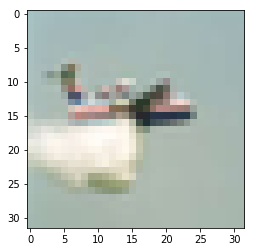

In [36]:
%%time
valid_x, valid_y = next(make_image_gen_cat(train_df))
print(valid_x.shape, valid_y.shape)

n = 16
plt.imshow(valid_x[n,:,:])
print(valid_y[n])

In [40]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import np_utils

In [57]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", 
                         input_shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(48, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(48, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

                # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(8, 8)))
        model.add(Dropout(0.4))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(classes))
        
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

In [58]:
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
                            depth=IMAGE_DIMS[2], classes=2, 
                            finalAct="sigmoid")
 
# initialize the optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_33 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_34 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
__________

In [60]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, dice_coef, acc, _ = self.model.evaluate(x, y, verbose=0)
        print('\n - Testing loss: {:.4f} - dice_coef: {:.4f} - acc: {:.4f}\n'.format(loss, dice_coef, acc))

In [61]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# weight_path="C:\\Users\\user\\Python_Code\\Kaggle\\Plane&Bird\\VGG16_easy_weights.h5"
weight_path = ''
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=3)



callbacks_list = [checkpoint, reduceLROnPlat]

gc.collect()

883

In [62]:
from keras import metrics
from keras import backend as K

model.compile(optimizer=Adam(1e-3, decay=1e-6), 
              loss="categorical_crossentropy",
              metrics=["accuracy", 
                      metrics.categorical_accuracy])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model)

In [63]:
BATCH_SIZE = 300
gen_train_cat = make_image_gen_cat(train_df)
gen_valid_cat = make_image_gen_cat(valid_df)

aug_gen_cat = create_aug_gen(make_image_gen_cat(train_df))


net = model.fit_generator(gen_train_cat,
                          steps_per_epoch = 100,
                          epochs = 50,
                          validation_data = gen_valid_cat,
                          validation_steps = 220,
                          callbacks = callbacks_list,
                          workers=1, 
                          verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
  2/100 [..............................] - ETA: 16:24 - loss: 0.8804 - acc: 0.5356 - categorical_accuracy: 0.5356

KeyboardInterrupt: 

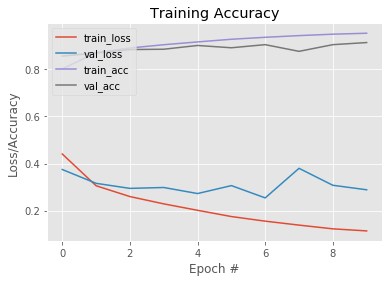

In [99]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0, N), net.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), net.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), net.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), net.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

In [164]:
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)
test_d1 = [[np.array(x)] for x in test_x.values]
test_d1 = {'map': test_d1}
test = pd.DataFrame(data=test_d1)

In [165]:
out_map = []
out_class = []
for index, row in test.iterrows():
    out_map += [pd.Series(row).values[0][0]]

out_map = np.array(out_map)
out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
out_map = np.stack(out_map, 0)

In [166]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

(4800, 2)
Wall time: 1.24 s


In [167]:
df = np.array([[i, x.argmax()] for i, x in enumerate(y_test_pred)])
sample = pd.DataFrame(df, columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})

In [168]:
sample.head()

,id,target
0,0,Airplane
1,1,Airplane
2,2,Bird
3,3,Airplane
4,4,Bird


In [169]:
sample.to_csv('output/submit_1.csv', index=False)